In [1]:
import mido
from utils import mido_setup, get_track_instrument_type
import os
import pandas
from collections import Counter
from matplotlib import pyplot as plt

In [8]:
initial_path = "/Users/edlgg/repos/dissertation/midis/v3/control_change/0_vel/120/"
path = initial_path
images_path = "/Users/edlgg/repos/dissertation/images/v3"
# images_out_path = "/Users/edlgg/repos/dissertation/results/images/v1"
# midi_out_path = "/Users/edlgg/repos/dissertation/results/midis/v1"

In [128]:
mid = mido.MidiFile(path + "pink_panther2.mid")

In [10]:
def get_max_length_mid(mid):
    max_length = 0
    for track in mid.tracks:
        length = 0
        for msg in track:
            if msg.type == "note_on":
                length = length + msg.time
        if length > max_length:
            max_length = length
    return max_length
get_max_length_mid(mid)

40757

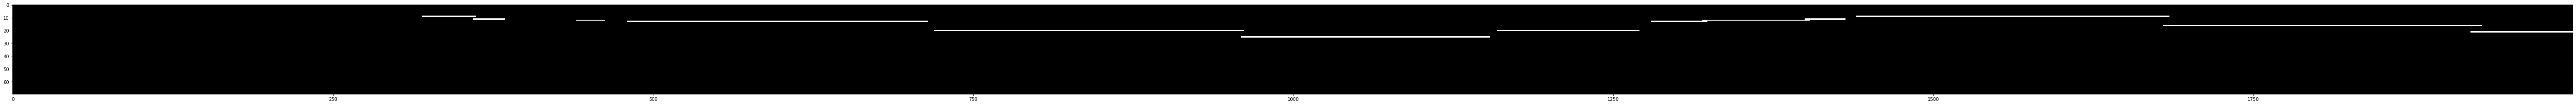

In [102]:
def track_to_image(track, length, include_velocity = True):
    image = [ [-1]*(length+1) for _ in range(90) ]
    note_locs = []
    time_step = 0
    for msg in track:
        if msg.type == "note_on":
            time_step = time_step + int(msg.time)
            
            if include_velocity:
                image[msg.note][time_step] = msg.velocity
            else:
                if msg.velocity != 0:
                    image[msg.note][time_step] = 1
                else:
                    image[msg.note][time_step] = 0
                
            if msg.velocity != 0:
                note_locs.append((msg.note, time_step))
                
    for note_loc in note_locs:
        y = note_loc[0]
        x = note_loc[1]
        vel = image[y][x]
        while image[y][x] != 0:
            image[y][x] = vel
            x = x + 1
            
    for i, row in enumerate(image):
        for j, e in enumerate(row):
            if image[i][j] == -1:
                image[i][j] = 0
                
    image = image[20:]
    inverted_image = []
    for row in image:
        inverted_image.insert(0, row)
#     return inverted_image
    return image
# image = track_to_image(mid.tracks[0], 108595)

def test_track_to_image(initial_path):
    song = mido.MidiFile(initial_path + "pink_panther2.mid")
    le = get_max_length_mid(song)
    image = track_to_image(song.tracks[0], le, False)
    
    x = [row[:2000] for row in image]
    plt.figure(figsize=(100,300))
    plt.imshow(x, cmap='gray', interpolation='nearest')
    plt.show()
test_track_to_image(initial_path)

In [103]:
def create_image_from_mid(mid, include_velocity = True):
    length = get_max_length_mid(mid)
    guitar_image = track_to_image(mid.tracks[0], length, include_velocity)
    bass_image = track_to_image(mid.tracks[1], length, include_velocity)
    return guitar_image + bass_image

def test_create_image_from_mid(mid):
    image = create_image_from_mid(mid, False)
    x = [row[-2000:] for row in image]
    plt.figure(figsize=(100,300))
    plt.imshow(x, cmap='gray', interpolation='nearest')
    plt.show()
# test_create_image_from_mid(mid)

In [104]:
def split_image(image, stride):
    images = []
    x = 2000
    while x <= len(image[0]):
        sub_image = [row[x-2000:x] for row in image]
        x = x + stride
        
        # Ensure pic has values
        guitar = sub_image[:70]
        count_guitar = 0
        for row in guitar:
            for e in row:
                if e != 0:
                    count_guitar = count_guitar + 1
        bass = sub_image[70:]
        count_bass = 0
        for row in guitar:
            for e in row:
                if e != 0:
                    count_bass = count_bass + 1
        if min(count_guitar, count_bass) > 200 and max(count_guitar, count_bass) > 1000:
            images.append(sub_image)
    return images

In [105]:
def create_images(initial_path, end_path):
    pass

In [119]:
class Message:
    def __init__(self, note, time_step, velocity):
        self.note = note
        self.time_step = time_step
        self.velocity = velocity
        self.time = -1
        
    def __str__(self):
         return "Message: note = " + str(self.note) + " time_step = " + str(self.time_step) + " vel = " + str(self.velocity) + " time = " + str(self.time)
        
def create_midi_track_from_image(track_image, instrument="Guitar"):    
    messages = []
    for note, row in enumerate(track_image):
        for time_step, e in enumerate(row):
            if time_step != 0 and time_step != len(track_image[0]) - 1:
                
                if track_image[note][time_step] != 0 and track_image[note][time_step-1] == 0:
                    messages.append(Message(note+20, time_step, track_image[note][time_step]))
                if track_image[note][time_step] != 0 and track_image[note][time_step+1] == 0:
                    messages.append(Message(note+20, time_step+1, 0))
                    
    for note, row in enumerate(track_image):
        if track_image[note][0] != 0 and track_image[note][1] != 0:
            messages.append(Message(note+20, 0, track_image[note][0]))
        if track_image[note][len(track_image[0]) - 1] != 0 and track_image[note][len(track_image[0]) - 2] != 0:
            messages.append(Message(note+20, len(track_image[0]) - 1, track_image[note][len(track_image[0]) - 1]))
            
    messages.sort(key=lambda x: x.time_step)
    
    for i, msg in enumerate(messages):
        if i == 0:
            msg.time = msg.time_step
        else:
            msg.time = msg.time_step - messages[i-1].time_step
    
    
    track = mido.MidiTrack()
    instrumet_type = 26
    if instrument == "Bass":
        instrumet_type = 34
    track.append(mido.Message('program_change', program=instrumet_type, time=0))
    for msg in messages:
        track.append(mido.Message('note_on', note=msg.note, velocity=msg.velocity, time=msg.time))
    
    return track
                
    

In [125]:
def create_midi_from_image(image):
    guitar_image = image[:70]
    bass_image = image[70:]
    
    guitar_track = create_midi_track_from_image(guitar_image, "Guitar")
    bass_track = create_midi_track_from_image(bass_image, "Bass")
    
    mid = mido.MidiFile()
    mid.ticks_per_beat = 120
    mid.tracks.append(guitar_track)
    mid.tracks.append(bass_track)
    return mid

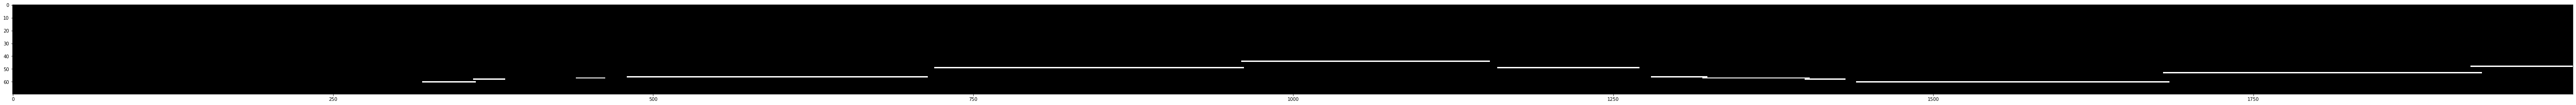

70


In [123]:
image = create_image_from_mid(mid, False)
images = split_image(image, 500)
image = images[0]
guitar_image = image[:70]
inverted_image = []
for row in guitar_image:
    inverted_image.insert(0, row)
guitar_image = inverted_image
plt.figure(figsize=(100,300))
plt.imshow(guitar_image, cmap='gray', interpolation='nearest')
plt.show()
messages = create_midi_track_from_image(guitar_image)
print(len(guitar_image))

In [129]:
mid2 = create_midi_from_image(image)
mid2.save("/Users/edlgg/Desktop/mid.mid")

In [115]:
for msg in messages:
    print(msg)

Message: note = 29 time_step = 320 vel = 1 time = 320
Message: note = 31 time_step = 360 vel = 1 time = 40
Message: note = 29 time_step = 362 vel = 0 time = 2
Message: note = 31 time_step = 385 vel = 0 time = 23
Message: note = 32 time_step = 440 vel = 1 time = 55
Message: note = 32 time_step = 463 vel = 0 time = 23
Message: note = 33 time_step = 480 vel = 1 time = 17
Message: note = 33 time_step = 715 vel = 0 time = 235
Message: note = 40 time_step = 720 vel = 1 time = 5
Message: note = 45 time_step = 960 vel = 1 time = 240
Message: note = 40 time_step = 962 vel = 0 time = 2
Message: note = 45 time_step = 1154 vel = 0 time = 192
Message: note = 40 time_step = 1160 vel = 1 time = 6
Message: note = 40 time_step = 1271 vel = 0 time = 111
Message: note = 33 time_step = 1280 vel = 1 time = 9
Message: note = 32 time_step = 1320 vel = 1 time = 40
Message: note = 33 time_step = 1324 vel = 0 time = 4
Message: note = 31 time_step = 1400 vel = 1 time = 76
Message: note = 32 time_step = 1404 vel 

In [116]:
for i in range(26):
    print(mid.tracks[0][i])

program_change channel=0 program=26 time=0
note_on channel=8 note=29 velocity=86 time=320
note_on channel=8 note=31 velocity=127 time=40
note_on channel=8 note=29 velocity=0 time=2
note_on channel=8 note=31 velocity=0 time=23
note_on channel=8 note=32 velocity=104 time=55
note_on channel=8 note=32 velocity=0 time=23
note_on channel=8 note=33 velocity=104 time=17
note_on channel=8 note=33 velocity=0 time=235
note_on channel=8 note=40 velocity=95 time=5
note_on channel=8 note=45 velocity=110 time=240
note_on channel=8 note=40 velocity=0 time=2
note_on channel=8 note=45 velocity=0 time=192
note_on channel=8 note=40 velocity=104 time=6
note_on channel=8 note=40 velocity=0 time=111
note_on channel=8 note=33 velocity=110 time=9
note_on channel=8 note=32 velocity=126 time=40
note_on channel=8 note=33 velocity=0 time=4
note_on channel=8 note=31 velocity=116 time=76
note_on channel=8 note=32 velocity=0 time=4
note_on channel=8 note=31 velocity=0 time=28
note_on channel=8 note=29 velocity=77 tim

In [187]:
def save_images_to_csv(images):
    pass

In [ ]:
def load_images_from_csv(path):
    pass